## PWAD - models + obs

PWAD - Precipitation Weighted Area Distribution <br>

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import skimage.measure as skm

from os.path import expanduser
home = expanduser("~")

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from metric_plotFuncs import *

In [2]:
models = [
    # 'IPSL-CM5A-MR', # 1
    'GFDL-CM3',       # 2
    # 'GISS-E2-H',    # 3
    # 'bcc-csm1-1',   # 4
    # 'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    # 'HadGEM2-AO',   # 7
    # 'BNU-ESM',      # 8
    # 'EC-EARTH',     # 9
    # 'FGOALS-g2',    # 10
    # 'MPI-ESM-MR',   # 11
    # 'CMCC-CM',      # 12
    # 'inmcm4',       # 13
    # 'NorESM1-M',    # 14
    # 'CanESM2',      # 15
    # 'MIROC5',       # 16
    # 'HadGEM2-CC',   # 17
    # 'MRI-CGCM3',    # 18
    # 'CESM1-BGC'     # 19
    # ''
    ]
model = models[0]

observations = [
    'GPCP'
    # ''
    ]
obs = observations[0]

experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]   

variable_options = [
    'pwad'
    ]
variable_option = variable_options[0]


if model:
    precip = xr.open_dataset(home + '/Documents/data/cmip5/ds' + '/' + model + '_precip_' + experiment + '.nc').precip*60*60*24
    precip.attrs['units']= 'mm/day'

    var = xr.open_dataset(home + '/Documents/data/cmip5/' + model + '/' + model + '_rome_' + experiment + '.nc')[variable_option]

if obs:
    precip_obs = xr.open_dataset(home + '/Documents/data/obs/ds' + '/' + obs + '_precip.nc').precip
    var_obs = xr.open_dataset(home + '/Documents/data/obs/GPCP' + '/' + obs + '_rome.nc')[variable_option]

### convective threshold and area fraction

In [5]:
pr_percentiles = calc_pr_percentiles(precip) # from prFuncs
pr_percentiles

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    pr95     (time) float64 14.08 13.81 14.17 14.02 ... 16.82 16.76 16.91 15.32
    pr97     (time) float64 17.44 17.1 17.44 17.31 ... 20.42 21.26 21.76 19.81
    pr99     (time) float64 25.16 28.12 26.33 25.34 ... 25.66 29.67 33.37 31.73
    pr999    (time) float64 46.43 56.0 75.17 68.38 ... 41.02 47.47 67.33 72.96

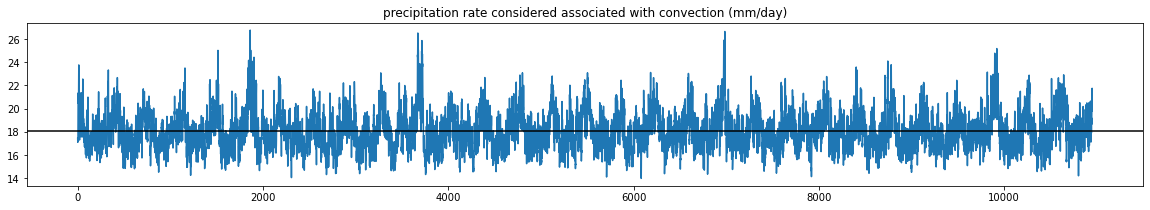

In [6]:
percentile = 'pr97'
conv_threshold = pr_percentiles[percentile].mean(dim=('time'))
plt.figure(figsize= (20,3))
plt.plot(pr_percentiles[percentile])
plt.title('precipitation rate considered associated with convection (mm/day)')
plt.axhline(y=conv_threshold, color='k')

In [7]:
start = timeit.default_timer()
numberIndex = calc_numberIndex(precip, conv_threshold) # from aggFuncs
stop = timeit.default_timer()
print('it takes {} seconds to calculate the number index for model: {}'.format((stop-start), model))

it takes 24.745860625 seconds to calculate the number index for model: GFDL-CM3


In [8]:
numberIndex

<xarray.Dataset>
Dimensions:   (time: 10950)
Coordinates:
  * time      (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    o_number  (time) float64 16.0 13.0 14.0 12.0 14.0 ... 17.0 16.0 21.0 16.0
    areaf     (time) float64 0.0282 0.02754 0.02669 ... 0.04735 0.04395 0.03731

Text(0.5, 1.0, 'areafraction covered by convection, defined from average percentile precipiitaiton rate (fixed precipitation rate)')

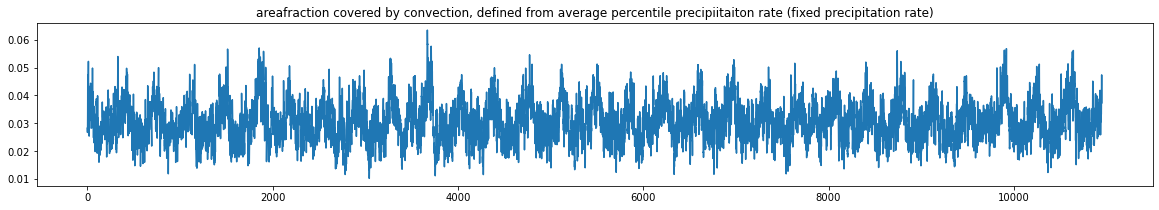

In [9]:
plt.figure(figsize= (20,3))
plt.plot(numberIndex.areaf)
plt.title('areafraction covered by convection, defined from average percentile precipiitaiton rate (fixed precipitation rate)')

### PWAD

In [10]:
start = timeit.default_timer()
pwad = calc_pwad(precip, conv_threshold) # from AggFuncs
stop = timeit.default_timer()
print('it takes {} seconds to calculate components of pwad for model: {}'.format((stop-start), model))

it takes 18.982780416999994 seconds to calculate components of pwad for model: GFDL-CM3


In [11]:
pwad

<xarray.Dataset>
Dimensions:   (dim_0: 13)
Dimensions without coordinates: dim_0
Data variables:
    pwad      (dim_0) float64 0.0 0.01032 0.1635 ... 0.002222 0.0006714 0.0
    bins_mid  (dim_0) float64 0.0 0.0 0.01472 0.02944 ... 0.1325 0.1472 0.1619

Text(0.5, 1.0, 'Precipitation Weighted Area Distribution')

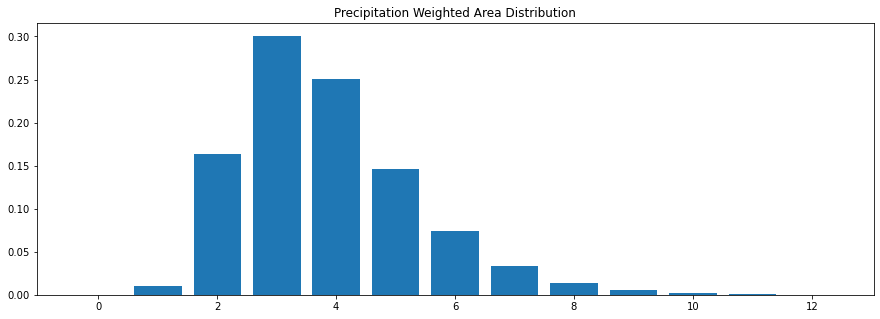

In [12]:
plt.figure(figsize = (15,5))
plt.bar(np.arange(0,13),pwad.pwad)
plt.title('Precipitation Weighted Area Distribution')

Text(0.5, 1.0, 'Precipitation Weighted Area Distribution')

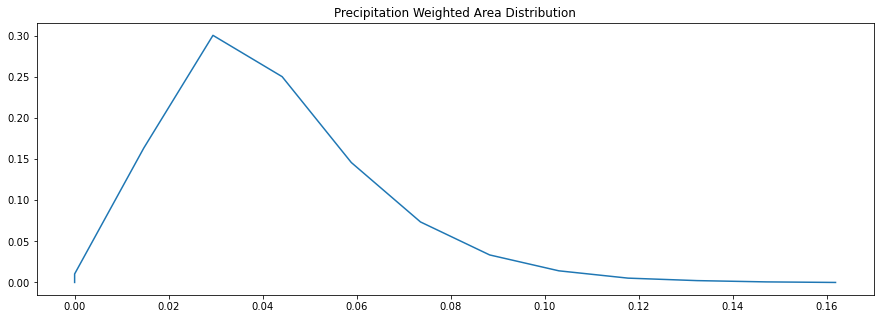

In [13]:
plt.figure(figsize = (15,5))
plt.plot(pwad.bins_mid,pwad.pwad)
plt.title('Precipitation Weighted Area Distribution')

In [14]:
saveit = False
if saveit:
    fileName = model + '_pwad_' + experiment + '.nc'
    dataset = xr.Dataset({'pwad':pwad})

    if switch['local_files']:
        folder = home + '/Documents/data/cmip5/' + model

    if switch['nci_files']:
        folder = '/g/data/k10/cb4968/data/cmip5/'+ model
        
    if switch['constructed_fields']:
        fileName = 'constructedFields' + '_pwad_' + experiment + '.nc'
        folder = home + '/Documents/data/cmip5/' + model

    save_file(dataset, folder, fileName) # from vars.myFuncs